In [1]:
import os, sys, re, json, time
from importlib import reload
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import tensorflow as tf
from IPython.display import display, clear_output 

/home/samird121/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Implement a Weak Annotator

### Read the All the News Data

In [2]:
articles_1=pd.read_csv('/home/kctobin/.kaggle/datasets/snapcrack/all-the-news/articles1.csv')
articles_2=pd.read_csv('/home/kctobin/.kaggle/datasets/snapcrack/all-the-news/articles2.csv')
articles_3=pd.read_csv('/home/kctobin/.kaggle/datasets/snapcrack/all-the-news/articles3.csv')

In [3]:
all_articles=pd.concat([articles_1,articles_2,articles_3],ignore_index=True)
np.unique(all_articles['publication'].tolist())

array(['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN',
       'Fox News', 'Guardian', 'NPR', 'National Review', 'New York Post',
       'New York Times', 'Reuters', 'Talking Points Memo', 'Vox',
       'Washington Post'],
      dtype='<U19')

### Create Training and Dev Sets

In [4]:
breitbart=all_articles.loc[all_articles['publication']=='Breitbart'].iloc[0:1000]
nat_review=all_articles.loc[all_articles['publication']=='National Review'].iloc[0:1000]
cnn=all_articles.loc[all_articles['publication']=='CNN'].iloc[0:1000]
guardian=all_articles.loc[all_articles['publication']=='Guardian'].iloc[0:1000]
reuters=all_articles.loc[all_articles['publication']=='Reuters'].iloc[0:1000]
bi=all_articles.loc[all_articles['publication']=='Business Insider'].iloc[0:1000]
full=pd.concat([breitbart,nat_review,cnn,guardian,reuters,bi],ignore_index=True)
shuffle=np.random.permutation(np.arange(full.shape[0]))
values_dict={'CNN': 0,'Guardian':0,'Reuters':1,'Business Insider':1,'Breitbart':2,'National Review':2}
full['label']=full['publication'].map(values_dict)

X,y=full['content'].iloc[shuffle].as_matrix(),full['label'].iloc[shuffle].as_matrix()
train_length=int(shuffle.shape[0]*0.8)
X_train,y_train=X[:train_length],y[:train_length]
X_dev,y_dev=X[train_length:],y[train_length:]

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(4800,)
(4800,)
(1200,)
(1200,)


### Fit Count Vectorizer with bigrams

In [5]:
vec=CountVectorizer(ngram_range=(2,2))
#vec=TfidfVectorizer(ngram_range=(2,2))
feature_mat=vec.fit_transform(X_train)
dev_mat=vec.transform(X_dev)

### train logistic regression model

In [6]:
from sklearn import metrics
Reg=LogisticRegression(penalty='l2')
Reg.fit(feature_mat,y_train)
weights=Reg.coef_
features=vec.get_feature_names()
preds=Reg.predict(dev_mat)
f1=metrics.f1_score(y_dev,preds,average='micro')
print(f1)

0.836666666667


### Process IBC Frame

In [2]:
ibc_frame=pd.read_csv('full_ibc_sentences.csv')
ibc_values_dict={'Liberal':0,'Neutral':1,'Conservative':2}
ibc_frame['class']=ibc_frame['label'].map(ibc_values_dict)
sentences=ibc_frame['sentence'].as_matrix()
labels=ibc_frame['class'].as_matrix()

### Annotate IBC Sentences

In [6]:
test_mat=vec.transform(sentences)
weak_annotation=Reg.predict_proba(test_mat)
print(weak_annotation.shape)
print(weak_annotation[1])

NameError: name 'vec' is not defined

## Using Reddit post weak labels

In [3]:
reddit_labels = pd.read_csv('./reddit_post_data/IBC_weak_labels.csv')
print(reddit_labels.head())
weak_annotation = [[row['con_score'], row['lib_score'], row['neu_score']] for index, row in reddit_labels.iterrows()]
print(len(weak_annotation))
print(weak_annotation[1])

   Unnamed: 0    label                                           sentence  \
0           0  Liberal  Forcing middle-class workers to bear a greater...   
1           1  Liberal  Because it would not be worthwhile to bring a ...   
2           2  Liberal  Indeed , Lind argues that high profits and hig...   
3           3  Liberal  In fairness , it should be noted that he devot...   
4           4  Liberal  Psychological tactics are social control techn...   

   con_score  lib_score  neu_score prediction  
0   0.220813   0.765276   0.013911    liberal  
1   0.176175   0.757604   0.066221    liberal  
2   0.300508   0.567023   0.132469    liberal  
3   0.373750   0.568598   0.057652    liberal  
4   0.076549   0.807958   0.115493    liberal  
4326
[0.17617473418035776, 0.7576040325326956, 0.06622123328694668]


# Calculate Confidence Scores

In [4]:
true_labels=pd.get_dummies(ibc_frame['class']).as_matrix()
print(true_labels[1])
#confidence_score=1-(float(1/true_labels.shape[1])*np.linalg.norm(true_labels-weak_annotation,axis=1))
confidence_score=1-(float(1/true_labels.shape[1])*np.sum(np.abs(true_labels-weak_annotation),axis=1))
ibc_frame['score']=pd.Series(confidence_score)
print(confidence_score[1])
print(confidence_score.shape)

[1 0 0]
0.45078315612
(4326,)


In [5]:
print(weak_annotation[1])
print(true_labels[1])
print(true_labels[1]-weak_annotation[1])
print(1-(np.sum(np.abs(true_labels[1]-weak_annotation[1]))/3.0))

[0.17617473418035776, 0.7576040325326956, 0.06622123328694668]
[1 0 0]
[ 0.82382527 -0.75760403 -0.06622123]
0.45078315612


In [6]:
ibc_frame['score']=pd.Series(confidence_score)
ibc_frame

,label,sentence,class,score
0,Liberal,Forcing middle-class workers to bear a greater...,0,0.480542
1,Liberal,Because it would not be worthwhile to bring a ...,0,0.450783
2,Liberal,"Indeed , Lind argues that high profits and hig...",0,0.533672
3,Liberal,"In fairness , it should be noted that he devot...",0,0.582500
4,Liberal,Psychological tactics are social control techn...,0,0.384366
5,Liberal,The uncontrolled profit motive is destroying h...,0,0.700614
6,Liberal,Organizations representing the religious right...,0,0.468673
7,Liberal,A market based on greed and fear has tugged on...,0,0.666560
8,Liberal,THE CONSERVATIVE MOVEMENT IS ROOTED IN A COHER...,0,0.736430
9,Liberal,"By eliminating the private insurer , you could...",0,0.504475


# Turn IBC Sentences into Matrices of Features for Confidence Network

### Divide Data into Train and Dev Sets

In [13]:
shuffle=np.random.permutation(np.arange(ibc_frame.shape[0]))
X,y=ibc_frame['sentence'].iloc[shuffle],ibc_frame['score'].iloc[shuffle]
train_length=int(ibc_frame.shape[0]*0.8)
X_train,y_train, true_y_train =X.iloc[:train_length],y.iloc[:train_length], 
X_dev,y_dev=X.iloc[train_length:],y.iloc[train_length:]

train_sentences=X_train.tolist()
train_labels=y_train.as_matrix()
dev_sentences=X_dev.tolist()
dev_labels=y_dev.as_matrix()



ValueError: not enough values to unpack (expected 3, got 2)

In [12]:
train

NameError: name 'train_labels' is not defined

In [12]:
print(train_sentences[0:3])
print(len(train_sentences))
print(train_labels[0:3])
print(len(train_labels))
print(dev_sentences[0:3])
print(len(dev_sentences))
print(dev_labels[0:3])
print(len(dev_labels))

['The purpose of churches is to repress , control , devalue , and destroy , as an unbroken history of religious violence and repression supposedly demonstrates .', 'Abstract : Johnston shows why lowincome people using the earned income tax credit are far more likely to be audited than rich people using baroque tax shelters .', 'That sense of insecurity will make a person less likely to invest in specialized training , cultivate new career paths , aggressively change jobs-the very things that are likely to allow that person to get ahead .']
3460
[ 0.70735312  0.80075505  0.43113056]
3460
['In the case of the retirement age , we should be asking whether we really intended to create what Social Security has becomeincreasingly a retirement system for people in middle age , most of whom report good or excellent health .', 'For instance , the Motion Picture Code ensured that scripts upheld the value of human life , that sin and wrongdoing were not justified , that brutality , indecent exposu

### Create Count Vectorizer For the Training Data to get word indices

In [13]:
vec=CountVectorizer()
feature_mat=vec.fit_transform(train_sentences)
vocab=vec.get_feature_names()
print(len(vocab))
#print(vec.vocabulary_)

13320


### Create arrays of word indices with the specified max sentence length

In [14]:
def make_index_list(vectorizer,max_len,sentences):
    analyze=vectorizer.build_analyzer()
    sents=[]
    ns=[]
    d=vec.vocabulary_
    dummy_index=len(vocab)
    for sentence in sentences:
        tokenized_sentence=analyze(sentence)[0:max_len]
        word_indices=[d.get(i) if d.get(i) is not None else dummy_index for i in tokenized_sentence]
        n=len(word_indices)
        if(n<max_len):
            pad_length=max_len-n
            word_indices=word_indices + [dummy_index] * pad_length

        sents.append(word_indices)
        ns.append(n)
    return np.array(sents,dtype=np.dtype(np.int32)), np.array(ns,dtype=np.dtype(np.int32))

In [15]:
max_len=55
train_list,train_ns=make_index_list(vec,max_len,train_sentences)
dev_list,dev_ns=make_index_list(vec,max_len,dev_sentences)

# Train Neural Net Using Tensorflow

In [18]:
from IPython.display import display, clear_output 

10) RMSE = 0.0271


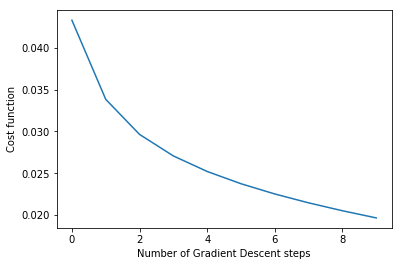

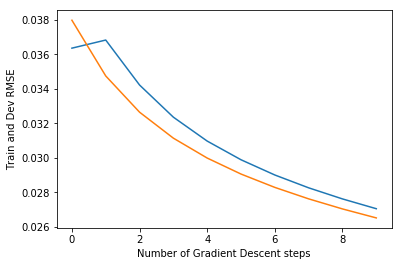

In [19]:
# (1) Parameters
tf.reset_default_graph()
embed_dim=25
hidden_layer_size=10
V=len(vocab)+1
learning_rate=0.01
batch_size=50
num_ex=train_list.shape[0]

# placeholder
x_=tf.placeholder(tf.int32,shape=[None,max_len],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.float32,shape=[None],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')


#define embedding/bow encoding layers

def embedding_layer(x_,V,embed_dim, init_scale=0.001):
    W_embed_=tf.get_variable("W_embed",[V,embed_dim],dtype=tf.float32,initializer=tf.random_uniform_initializer(-init_scale,init_scale))
    xs_=tf.nn.embedding_lookup(W_embed_,x_)
    return xs_

def bow_encoding_layer(x_,ns_,V,embed_dim,is_training=None):
    xs_=embedding_layer(x_,V,embed_dim)
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, xs_.shape[1],dtype=tf.float32), -1)
    xs_=tf.multiply(xs_,mask_)
    sum_embeddings=tf.reduce_sum(xs_,axis=1)
    return sum_embeddings

#define model with one bow encoding layer, one hidden layer, and one output layer

def model(x_,ns_,V,embed_dim,hidden_layer_size,is_training=True):
    l1=bow_encoding_layer(x_,ns_,V,embed_dim)
    l2=tf.layers.dense(inputs=l1,units=hidden_layer_size,activation=tf.tanh)
    output_layer=tf.layers.dense(inputs=l2,units=1,activation=tf.nn.relu)
    return tf.squeeze(output_layer)

#Define training op and optimizer
preds=model(x_,ns_,V,embed_dim,hidden_layer_size,is_training_)
cc=tf.losses.mean_squared_error(y_,preds)
gd=tf.train.GradientDescentOptimizer(learning_rate)
outputs=tf.identity(preds)

step=gd.minimize(cc)

#Calculate error
acc=tf.metrics.mean_squared_error(y_,preds)[1]

#get probabilities
proba = y_

#Train the Neural network, report dev/training accuracies
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    acc_dev_vec = []
    acc_train_vec = []
    for i in range(10):
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            batch = train_list[start:end], train_labels[start:end]
            ns=train_ns[start:end]
            _, cost = sess.run([step, cc], feed_dict={x_: batch[0],ns_: ns, y_: batch[1], is_training_: True})

        dev_acc = acc.eval(feed_dict={x_: dev_list,ns_: dev_ns, y_: dev_labels, is_training_: False})
        train_acc = acc.eval(feed_dict={x_: train_list,ns_: train_ns, y_: train_labels,is_training_: False})

        cost_vec.append(cost)
        clear_output(wait=True)
        acc_dev_vec.append(dev_acc)
        acc_train_vec.append(train_acc)
        print('%d) RMSE = %.4f' %(i+1, dev_acc))
    probas = proba.eval(feed_dict={x_: train_list,ns_: train_ns, y_: train_labels,is_training_: False})


#plot the results
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev RMSE')
plt.show()


In [20]:
probas

array([ 0.33491096,  0.37973127,  0.59558648, ...,  0.46593711,
        0.97937685,  0.51157415], dtype=float32)

# Neural Network with Pretrained Embeddings

### Load the pre-trained Google embeddings

In [2]:
import gensim

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

### Divide Data into Training, Dev, and Test Sets

In [14]:
true_labels[train_length+test_length:]

NameError: name 'test_length' is not defined

In [15]:
shuffle=np.random.permutation(np.arange(ibc_frame.shape[0]))
X,y=ibc_frame['sentence'].iloc[shuffle],ibc_frame['score'].iloc[shuffle]
train_length=int(ibc_frame.shape[0]*0.7)
test_length=int((ibc_frame.shape[0]-train_length) * (2.0/3.0))
X_train,y_train, true_y_train=X.iloc[:train_length],y.iloc[:train_length], true_labels[:train_length]
X_test,y_test=X.iloc[train_length:train_length+test_length],y.iloc[train_length:train_length+test_length]
X_dev,y_dev, true_y_dev=X.iloc[train_length+test_length:],y.iloc[train_length+test_length:], true_labels[train_length+test_length:]

train_sentences=X_train.tolist()
train_labels=y_train.as_matrix()
test_sentences=X_test.tolist()
test_labels=y_test.as_matrix()
dev_sentences=X_dev.tolist()
dev_labels=y_dev.as_matrix()

In [18]:
print(true_y_train[0:3])
print(true_y_dev[0:3])

[[1 0 0]
 [1 0 0]
 [1 0 0]]
[[0 1 0]
 [0 1 0]
 [0 1 0]]


In [95]:
print(train_sentences[0:3])
print(len(train_sentences))
print(train_labels[0:3])
print(len(train_labels))
print(test_sentences[0:3])
print(len(test_sentences))
print(test_labels[0:3])
print(len(test_labels))
print(dev_sentences[0:3])
print(len(dev_sentences))
print(dev_labels[0:3])
print(len(dev_labels))


['In Atlas Shrugged , her hero , John Galt , leads a capitalist strike , in which the brilliant business leaders who drive all progress decide that they will no longer tolerate the parasitic workers exploiting their talent , and so they withdraw from society to create their own capitalistic paradise free of the ungrateful , incompetent masses .', 'Any failure traceable to arrogance , or our lack of comprehension or readiness to sacrifice , would inflict upon us grievous hurt , both at home and abroad .', 'Affordable housing frees up resources for food and health care , reduces stress and stress-related health problems , alleviates over-crowding , and allows access to neighborhood resources .']
3028
[ 0.51119463  0.36209301  0.33755605]
3028
['We thank the Ford Foundation for supporting our work on good jobs and economic development , and The Atlantic Philanthropies for supporting our work on immigration .', "Waugh believed that mankind did not divide `` into the rich and poor , the pri

### Define Preprocessor for Text - For Now Just Use Default from CountVectorizer

In [96]:
sentences=ibc_frame['sentence'].tolist()
proc_vec=CountVectorizer()
#feature_mat=proc_vec.fit_transform(sentences)
analyze=proc_vec.build_analyzer()
split_sentences=[analyze(i) for i in sentences]
print(split_sentences[10])

['the', 'additional', 'schooling', 'foisted', 'upon', 'one', 'group', 'by', 'this', 'arbitrary', 'state', 'of', 'affairs', 'produced', 'scaled', 'down', 'version', 'of', 'our', 'experiment', 'allowing', 'angrist', 'and', 'krueger', 'to', 'conclude', 'that', 'education', 'did', 'in', 'fact', 'help', 'people', 'earn', 'more', 'money']


### Pre-Process training, dev, and test sets

In [97]:
def make_sentence_list(pre_proc,max_len,sentences):
    sents=[]
    ns=[]
    for sentence in sentences:
        processed_sentence=pre_proc(sentence)
        n=len(processed_sentence)
        if(n<max_len):
            pad_length=max_len-n
            processed_sentence=processed_sentence + ['000'] * pad_length

        sents.append(processed_sentence[0:max_len])
        ns.append(n)

    
    return np.array(sents), np.array(ns)

In [98]:
max_len=55

train_list,train_ns=make_sentence_list(analyze,max_len,train_sentences)
dev_list,dev_ns=make_sentence_list(analyze,max_len,dev_sentences)
test_list,test_ns=make_sentence_list(analyze,max_len,test_sentences)

print(train_list.shape)
print(train_ns.shape)
print(test_list.shape)
print(test_ns.shape)
print(dev_list.shape)
print(dev_ns.shape)

print(train_list[0])

(3028, 55)
(3028,)
(865, 55)
(865,)
(433, 55)
(433,)
['in' 'atlas' 'shrugged' 'her' 'hero' 'john' 'galt' 'leads' 'capitalist'
 'strike' 'in' 'which' 'the' 'brilliant' 'business' 'leaders' 'who' 'drive'
 'all' 'progress' 'decide' 'that' 'they' 'will' 'no' 'longer' 'tolerate'
 'the' 'parasitic' 'workers' 'exploiting' 'their' 'talent' 'and' 'so'
 'they' 'withdraw' 'from' 'society' 'to' 'create' 'their' 'own'
 'capitalistic' 'paradise' 'free' 'of' 'the' 'ungrateful' 'incompetent'
 'masses' '000' '000' '000' '000']


### Embed The train, test, and dev sentences

In [99]:
def embed_sentences(sentence_array,unknown_word_embedding):
    data=np.zeros([sentence_array.shape[0],sentence_array.shape[1],300])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            try:
                data[i][j]=model[train_list[i][j]]
            except:
                data[i][j]=unknown_word_embedding
    return data
        

In [100]:
unknown_word_embedding=np.random.rand(1,300)

train_data=embed_sentences(train_list,unknown_word_embedding)
dev_data=embed_sentences(dev_list,unknown_word_embedding)
test_data=embed_sentences(test_list,unknown_word_embedding)

print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)


(3028, 55, 300)
(433, 55, 300)
(865, 55, 300)


### Implement the Neural Network

In [101]:
from IPython.display import display, clear_output 

100) RMSE = 0.2953


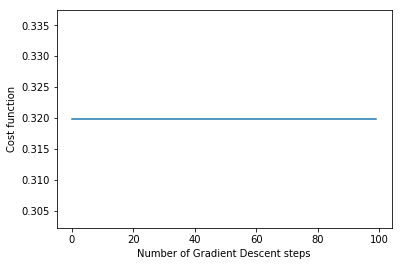

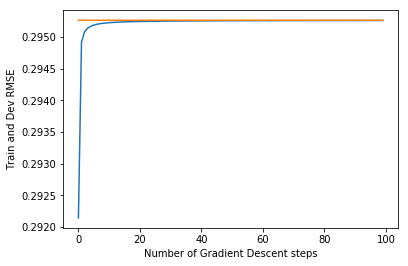

In [102]:
# (1) Parameters
tf.reset_default_graph()
hidden_layer_size=10
learning_rate=0.01
batch_size=50
num_ex=train_data.shape[0]

# placeholder
x_=tf.placeholder(tf.float32,shape=[None,max_len,300],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.float32,shape=[None],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')


#define bow encoding layers


def bow_encoding_layer(x_,ns_,is_training=None):
    mask_ = tf.expand_dims(tf.sequence_mask(ns_, x_.shape[1],dtype=tf.float32), -1)
    x_=tf.multiply(x_,mask_)
    sum_embeddings=tf.reduce_sum(x_,axis=1)
    return sum_embeddings

#define model with one bow encoding layer, one hidden layer, and one output layer

def model(x_,ns_,hidden_layer_size,is_training=True):
    l1=bow_encoding_layer(x_,ns_)
    l2=tf.layers.dense(inputs=l1,units=hidden_layer_size,activation=tf.tanh)
    output_layer=tf.layers.dense(inputs=l2,units=1,activation=tf.nn.relu)
    return tf.squeeze(output_layer)

#Define training op and optimizer
preds=model(x_,ns_,hidden_layer_size,is_training_)
cc=tf.losses.mean_squared_error(y_,preds)
gd=tf.train.GradientDescentOptimizer(learning_rate)
outputs=tf.identity(preds)

step=gd.minimize(cc)

#Calculate error
acc=tf.metrics.mean_squared_error(y_,preds)[1]



#Train the Neural network, report dev/training accuracies
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    acc_dev_vec = []
    acc_train_vec = []
    for i in range(100):
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            batch = train_data[start:end], train_labels[start:end]
            ns=train_ns[start:end]
            _, cost = sess.run([step, cc], feed_dict={x_: batch[0],ns_: ns, y_: batch[1], is_training_: True})

        dev_acc = acc.eval(feed_dict={x_: dev_data,ns_: dev_ns, y_: dev_labels, is_training_: False})
        train_acc = acc.eval(feed_dict={x_: train_data,ns_: train_ns, y_: train_labels,is_training_: False})

        cost_vec.append(cost)
        clear_output(wait=True)
        acc_dev_vec.append(dev_acc)
        acc_train_vec.append(train_acc)
        print('%d) RMSE = %.4f' %(i+1, dev_acc))
    probas = preds.eval(feed_dict={x_: train_data,ns_: train_ns, y_: train_labels,is_training_: False})

#plot the results
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev RMSE')
plt.show()

In [32]:
probas3d = []
for i in range(len(probas)):
    probas3d.append(probas[i] * true_train_labels[i])

In [33]:
probas3d[0:3]

[array([ 0.51569659,  0.        ,  0.        ], dtype=float32),
 array([ 0.51569659,  0.        ,  0.        ], dtype=float32),
 array([ 0.51569659,  0.        ,  0.        ], dtype=float32)]

# Target Network

In [59]:
train_labels

array([ 0.44674849,  0.42791189,  0.33344867, ...,  0.85070372,
        0.36404848,  0.33375039])

10) Cross Entropy Loss = 0.0000


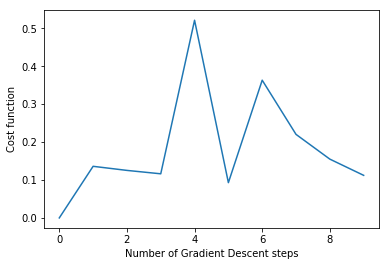

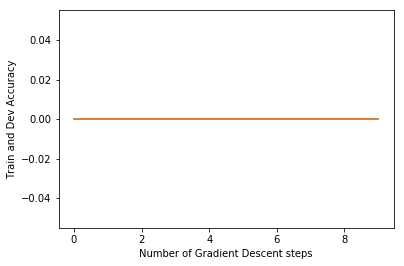

In [82]:
# Parameters
tf.reset_default_graph()
hidden_layer_size = 100
depth_size = 128
filters = [2,3,4]

learning_rate = 0.01
batch_size = 50
num_ex = train_list.shape[0]
num_classes = 3

# placeholder
x_=tf.placeholder(tf.float32,shape=[None, None, None],name='x')
ns_=tf.placeholder(tf.int32,shape=[None],name='ns')
y_=tf.placeholder(tf.int32,shape=[None, None],name='y')
is_training_ = tf.placeholder_with_default(True, shape=[], name='is_training')
pk1_ = tf.placeholder(tf.float32, shape=[], name='pk1')
pk2_ = tf.placeholder(tf.float32, shape=[], name='pk2')
pk3_ = tf.placeholder(tf.float32, shape=[], name='pk3')
c_=tf.placeholder(tf.float32,shape=[None],name='c')

max_time = train_data.shape[1]
embed = train_data.shape[2]


def CNN(input_x, filters, depth_size, is_training, pk1, max_time, embed):
    """CNN model

    Args:
      input_x: 3-d matrix of sentences converted to word embeddings [batch size, max_length, embed_dim]
      filters: array of filter sizes to use
      depth_size: number of filters of certain size to pass over input
      is_training: boolean that turns on or off dropout

    Returns:
      tensor object after convolutions are applied
    """
    #max_time = tf.shape(input_x)[1]
    #embed = tf.shape(input_x)[2]
    


    l1 = tf.reshape(input_x, [-1, max_time, embed, 1])
    
    l2 = tf.cond(is_training, 
                 lambda: tf.nn.dropout(l1, pk1),
                 lambda: l1)
    #if is_training:
    #    l2 = tf.nn.dropout(l1, pk1)
    #else:
    #    l2 = l1
    pooled_outputs = []
    
    
    for i, filter_size in enumerate(filters):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            w1 = tf.get_variable(shape=[filter_size, embed, 1, depth_size], name = 'w1'+str(filter_size))
            l3 = tf.nn.conv2d(l2, w1, [1,1,1,1], 'VALID')
            l4 = tf.nn.relu(l3)
            #l5 = tf.nn.max_pool(l4, [1, (max_time-filter_size+1), 1, 1], [1, 1, 1, 1], 'VALID')
            l5 = tf.nn.max_pool(l4, [1, (max_time-filter_size+1), 1, 1], [1, 1, 1, 1], 'VALID')
            
            #print('l3', l3.shape)
            #print('l4', l4.shape)
            #print('l5', l5.shape)
            
            pooled_outputs.append(l5)


    l5_pool = tf.concat(pooled_outputs, 3)
    #print(l5_pool.shape)
    l6 = tf.reshape(l5_pool, [-1, (depth_size * len(filters))])
    return l6

def target_model(input_x, filters, depth_size, h, num_classes, is_training, pk1, pk2, pk3, max_time, embed):
    """Total target model that applies convolutions through CCN method and
    then applies fully connected layer and softmax output layer.

    Args:
      input_x: 3-d matrix of sentences converted to word embeddings [batch size, max_length, embed_dim]
      filters: array of filter sizes to use
      depth_size: number of filters of certain size to pass over input
      h: int of hidden dimensions for fully connected layer
      num_classes: output dimensions for softmax layer
      is_training: boolean that turns on or off dropout

    Returns:
      logits of predicted class of sentence classification 
    """
    l6 = CNN(input_x, filters, depth_size, is_training, pk1, max_time, embed)
    
    w2 = tf.get_variable('w2', shape=[depth_size*len(filters), h])
    b2 = tf.get_variable('b2', shape=[h])
    w3 = tf.get_variable('w3', shape=[h, num_classes])
    b3 = tf.get_variable('b3', shape=[num_classes])
    
    l7 = tf.cond(is_training, 
                 lambda: tf.nn.dropout(l6, pk2),
                 lambda: l6)
    l8 = tf.matmul(l7, w2) + b2
    l9 = tf.nn.relu(l8)
    
    l10 = tf.cond(is_training, 
                  lambda: tf.nn.dropout(l9, pk3), 
                  lambda: l9)
    logits = tf.matmul(l10, w3) + b3
    #preds = tf.nn.softmax(logits)
    
    return logits

def loss(y, preds, c, is_training):
    """Total target model that applies convolutions through CCN method and
    then applies fully connected layer and softmax output layer.

    Args:
      y: actual labels
      preds: predicted classifications
      c: confidence scores

    Returns:
      training loss
    """

    loss = tf.cond(is_training, 
                  lambda: tf.losses.softmax_cross_entropy(y, preds, weights=c), 
                  lambda: tf.losses.softmax_cross_entropy(y, preds))
        
    return loss   
    


preds = target_model(x_, filters, depth_size, hidden_layer_size, num_classes, is_training_, pk1_, pk2_, pk3_, max_time, embed)
loss = loss(y_, preds, c_, is_training_)
optimizer = tf.train.AdamOptimizer(learning_rate)
outputs = tf.nn.softmax(preds)
pred_outs = tf.argmax(outputs)

step = optimizer.minimize(loss)

#Calculate error
acc=tf.metrics.accuracy(y_,pred_outs)[1]


with tf.Session() as sess:
    print('Starting training...')


    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
   
    
    cost_vec = []
    acc_dev_vec = []
    acc_train_vec = []
    for i in range(10):
        for start, end in zip(range(0, num_ex, batch_size), range(batch_size, num_ex, batch_size)):
            batch = train_data[start:end], true_y_train[start:end]
            ##insert code to include confidence scores here
            c_scores = probas[start:end]
            
            _, cost = sess.run([step, loss], feed_dict={x_: batch[0], y_: batch[1], is_training_: True, c_:c_scores,
                                                       pk1_: .8, pk2_: .8, pk3_: .8})

        dev_acc = acc.eval(feed_dict={x_: dev_data, y_: true_y_dev, is_training_: False})
        train_acc = acc.eval(feed_dict={x_: train_data, y_: true_y_train, is_training_: False})

        cost_vec.append(cost)
        clear_output(wait=True)
        acc_dev_vec.append(dev_acc)
        acc_train_vec.append(train_acc)
        print('%d) Cross Entropy Loss = %.4f' %(i+1, dev_acc))

#plot the results
plt.plot(cost_vec)  
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Cost function')
plt.show()

plt.plot(acc_dev_vec)  
plt.plot(acc_train_vec)
plt.xlabel('Number of Gradient Descent steps')
plt.ylabel('Train and Dev Accuracy')
plt.show()

In [ ]:
dev_num_labels = []
for label in true_dev_labels:

In [89]:
true_y_dev

array([], shape=(0, 3), dtype=uint8)